In [242]:
import numpy as np
import pandas as pd
import fasttext
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def initial_sampling(data, mainProb, mainCluster, clusterNum, batchSize):
    result = []
    otherProb = (1 - mainProb) / (clusterNum - 1)
    # set weights to clusters for sampling
    data['weights'] = 0
    data.loc[data['cluster'] == mainCluster,'weights'] = mainProb
    data.loc[data['cluster'] != mainCluster,'weights'] = otherProb
    # return the sampling index
    return list(data.sample(n=batchSize,weights=data['weights']).index.values)

def thompson_sampling(batchSize,clusterNum,data):
    # Thompson Sampling
    observations = batchSize
    machines = clusterNum
    sample_selected = []
    machine_selected = []

    rewards = [0]*machines
    penalties = [0]*machines
    total_reward = 0

    for n in range(observations):
        bandit = 0
        beta_max = 0

        for i in range(machines):
            beta_d = random.betavariate(rewards[i] + 1, penalties[i] + 1)
            if beta_d > beta_max:
                beta_max = beta_d
                bandit = i
        machine_selected.append(bandit)
        one_sample_index = data[data['cluster']=='__cluster__'+str(bandit)].sample(n=1).index.values[0]
        sample_selected.append(one_sample_index)
        if data.loc[one_sample_index]['label'] == '__label__2':
            reward = 1
        else:
            reward = 0
    #     reward = data.values[n,bandit]
        if reward == 1:
            rewards[bandit] = rewards[bandit] + 1
        else:
            penalties[bandit] = penalties[bandit] + 1
        total_reward = total_reward + reward
    return sample_selected, machine_selected, total_reward, rewards, penalties

def thompson_sampling_neg(batchSize,clusterNum,data):
    # Thompson Sampling
    observations = batchSize
    machines = clusterNum
    sample_selected = []
    machine_selected = []

    rewards = [0]*machines
    penalties = [0]*machines
    total_reward = 0

    for n in range(observations):
        bandit = 0
        beta_min = 999999

        for i in range(machines):
            beta_d = random.betavariate(penalties[i] + 1, rewards[i] + 1)
            if beta_d < beta_min:
                beta_min = beta_d
                bandit = i
        machine_selected.append(bandit)
        one_sample_index = data[data['cluster']=='__cluster__'+str(bandit)].sample(n=1).index.values[0]
        sample_selected.append(one_sample_index)
        if data.loc[one_sample_index]['label'] == '__label__1':
            reward = 1
        else:
            reward = 0
    #     reward = data.values[n,bandit]

        if reward == 1:
            rewards[bandit] = rewards[bandit] + 1
        else:
            penalties[bandit] = penalties[bandit] + 1
        total_reward = total_reward + reward
    return sample_selected, machine_selected, total_reward, rewards, penalties

def AL_selection(unlabeled, batchSize):
    # select the most representative data by index
    return list(unlabeled.sort_values(by ='prob')[:batchSize].index.values)

def split_train_unlabeled(sample_index,unlabeled):
    train = data.loc[sample_index]
    unlabel = unlabeled.drop(sample_index)
    train[['label','x']].to_csv('ALtrain.txt',sep = ' ',header = False,index = False)
    return train,unlabel

def test(model):
    test = open("./test.ft.txt",'r')
    test = test.readlines()
    print(len(test), 'number of records in the test set') 

    # To run the predict function, we need to remove the __label__1 and __label__2 from the testset.  
    new = [w.replace('__label__2 ', '') for w in test]
    new = [w.replace('__label__1 ', '') for w in new]
    new = [w.replace('\n', '') for w in new]

    # Use the predict function 
    pred = model.predict(new)
    
    # Lets recode the actual targets to 1's and 0's from both the test set and the actual predictions  
    labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test]
    pred_labels = [0 if x == ['__label__1'] else 1 for x in pred[0]]

    # run the accuracy measure. 
    return roc_auc_score(labels, pred_labels)

In [ ]:
# Random_sampling with different batch sizes
if __name__ == "__main__":
    with open('train_woLabel.txt','r') as f:
        x = pd.Series([i.strip() for i in f.readlines()])
    with open('label.txt','r') as f:
        y = pd.Series([i.strip() for i in f.readlines()])
    with open('cluster_label.txt','r') as f:
        cluster = pd.Series([i.strip() for i in f.readlines()])
    frame = { 'x': x, 'label': y, 'cluster': cluster }
    data =  pd.DataFrame(frame)
    
    
    clusterNum = 6
    mainProb = 1 / clusterNum
    batchSize = 1800
    batchNum = 10
    mainCluster = '__cluster__2'
    for initialSize in [i*600 for i in range(1,7)]:
        test_acc_list = []
        sample_index = []
        sample_index = sample_index + initial_sampling(data, mainProb, mainCluster, clusterNum, initialSize)
        train,unlabeled = split_train_unlabeled(sample_index,data)

        # train & test the model
        model = fasttext.train_supervised('ALtrain.txt',label_prefix='__label__', thread=1, epoch = 10, pretrainedVectors='model.vec')
        test_acc_list.append(test(model))

        for i in range(batchNum-1):
            # AL selection
            unlabeled['prob']=0
            unlabeled['prob'] = model.predict(unlabeled['x'].tolist())[1]
            sample_index = sample_index + AL_selection(unlabeled, batchSize)
            train,unlabeled = split_train_unlabeled(sample_index,data)
            # train & test the model
            model = fasttext.train_supervised('ALtrain.txt',label_prefix='__label__', thread=1, epoch = 10, pretrainedVectors='model.vec')
            test_acc_list.append(test(model))
        with open('test_acc_initial_size'+str(initialSize)+'.txt','w') as f:
            f.writelines(str(test_acc_list))

400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set


In [ ]:
# Single Cluster Concentration Method
if __name__ == "__main__":
    with open('train_woLabel.txt','r') as f:
        x = pd.Series([i.strip() for i in f.readlines()])
    with open('label.txt','r') as f:
        y = pd.Series([i.strip() for i in f.readlines()])
    with open('cluster_label.txt','r') as f:
        cluster = pd.Series([i.strip() for i in f.readlines()])
    frame = { 'x': x, 'label': y, 'cluster': cluster }
    data =  pd.DataFrame(frame)
    
    
    clusterNum = 6
    mainProb = 0.8
    batchSize = 7200
    batchNum = 10
    for mainCluster in ['__cluster__'+str(i) for i in range(6)]:
        test_acc_list = []
        sample_index = []
        sample_index = sample_index + initial_sampling(data, mainProb, mainCluster, clusterNum, batchSize)
        train,unlabeled = split_train_unlabeled(sample_index,data)

        # train & test the model
        model = fasttext.train_supervised('ALtrain.txt',label_prefix='__label__', thread=1, epoch = 10, pretrainedVectors='model.vec')
        test_acc_list.append(test(model))

        for i in range(batchNum-1):
            # AL selection
            unlabeled['prob']=0
            unlabeled['prob'] = model.predict(unlabeled['x'].tolist())[1]
            sample_index = sample_index + AL_selection(unlabeled, batchSize)
            train,unlabeled = split_train_unlabeled(sample_index,data)
            # train & test the model
            model = fasttext.train_supervised('ALtrain.txt',label_prefix='__label__', thread=1, epoch = 10, pretrainedVectors='model.vec')
            test_acc_list.append(test(model))
        with open('test_acc_initial_size'+str(initialSize)+'.txt','w') as f:
            f.writelines(str(test_acc_list))

In [244]:
# Thompson Sampling Method
if __name__ == "__main__":
    with open('train_woLabel.txt','r') as f:
        x = pd.Series([i.strip() for i in f.readlines()])
    with open('label.txt','r') as f:
        y = pd.Series([i.strip() for i in f.readlines()])
    with open('cluster_label.txt','r') as f:
        cluster = pd.Series([i.strip() for i in f.readlines()])
    frame = { 'x': x, 'label': y, 'cluster': cluster }
    data =  pd.DataFrame(frame)
    
#     mainProb = 0.8
#     mainCluster = '__cluster__4'
    clusterNum = 6
    batchSize = 7200
    batchNum = 10
    test_acc_list = []

    sample_index = []
    sample_selected, machine_selected, total_reward, rewards, penalties = thompson_sampling(int(batchSize/2),clusterNum,data)
    sample_index = sample_index + sample_selected
    train,unlabeled = split_train_unlabeled(sample_index,data)·
    sample_selected, machine_selected, total_reward, rewards, penalties = thompson_sampling_neg(batchSize-int(batchSize/2),clusterNum,unlabeled)
    sample_index = sample_index + sample_selected
    train,unlabeled = split_train_unlabeled(sample_index,data)

    # train & test the model
    model = fasttext.train_supervised('ALtrain.txt',label_prefix='__label__', thread=1, epoch = 10, pretrainedVectors='model.vec')
    test_acc_list.append(test(model))

    for i in range(batchNum-1):
        # AL selection
        unlabeled['prob']=0
        unlabeled['prob'] = model.predict(unlabeled['x'].tolist())[1]
        sample_index = sample_index + AL_selection(unlabeled, batchSize)
        train,unlabeled = split_train_unlabeled(sample_index,data)
        # train & test the model
        model = fasttext.train_supervised('ALtrain.txt',label_prefix='__label__', thread=1, epoch = 10, pretrainedVectors='model.vec')
        test_acc_list.append(test(model))
    with open('test_acc_thompson_sampling.txt','w') as f:
        f.writelines(str(test_acc_list))

400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set
400000 number of records in the test set


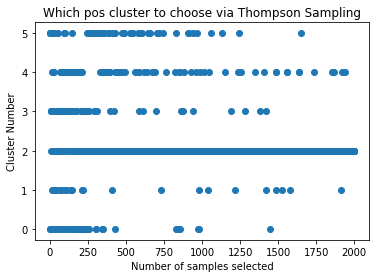

In [235]:
from matplotlib import pyplot as plt
plt.scatter(range(2000),machine_selected)
plt.title('Which pos cluster to choose via Thompson Sampling')
plt.xlabel('Number of samples selected')
plt.ylabel('Cluster Number')
plt.show()

In [197]:
from matplotlib import pyplot as plt
print("\n\nRewards By Machine = ", rewards)
print("\nTotal Rewards Obtained With Thompson Sampling = ", total_reward)
print("\nMachine Selected At Each Round By Thompson Sampling : \n", sample_selected)

#Visualizing the rewards of each machine
plt.bar(['B1','B2','B3','B4','B5','B6'],rewards)
plt.title('MABP')
plt.xlabel('Bandits')
plt.ylabel('Rewards By Each Machine')
plt.show()




Rewards By Machine =  [8, 0, 10, 14, 8, 9]

Total Rewards Obtained With Thompson Sampling =  49

Machine Selected At Each Round By Thompson Sampling : 
 [124366, 144637, 39343, 68822, 117214, 129872, 16896, 120267, 12010, 106313, 131116, 9467, 15468, 57053, 124497, 15421, 175096, 8751, 91616, 82954, 122099, 117100, 57395, 78162, 145336, 179168, 40829, 37499, 28610, 21989, 30919, 58879, 15876, 161150, 94339, 110471, 23357, 99160, 132396, 131047, 50860, 37268, 95124, 148360, 140823, 151525, 29358, 36369, 114460, 168285, 170975, 50398, 137112, 82086, 105809, 72658, 137187, 138465, 165184, 138704, 177179, 49572, 126761, 275, 28348, 67776, 61579, 95541, 163125, 150220, 135971, 122367, 115883, 107974, 76265, 17046, 147700, 116516, 133383, 47113, 105485, 75327, 148661, 77975, 92488, 26913, 38433, 131743, 32214, 90254, 158374, 146303, 49798, 146265, 62512, 149787, 6549, 18414, 30640, 10547]


<Figure size 640x480 with 1 Axes>



Number Of Times Each Machine Was Selected By the Thompson Sampling Algorithm : 
 {124366: 1, 144637: 1, 39343: 1, 68822: 1, 117214: 1, 129872: 1, 16896: 1, 120267: 1, 12010: 1, 106313: 1, 131116: 1, 9467: 1, 15468: 1, 57053: 1, 124497: 1, 15421: 1, 175096: 1, 8751: 1, 91616: 1, 82954: 1, 122099: 1, 117100: 1, 57395: 1, 78162: 1, 145336: 1, 179168: 1, 40829: 1, 37499: 1, 28610: 1, 21989: 1, 30919: 1, 58879: 1, 15876: 1, 161150: 1, 94339: 1, 110471: 1, 23357: 1, 99160: 1, 132396: 1, 131047: 1, 50860: 1, 37268: 1, 95124: 1, 148360: 1, 140823: 1, 151525: 1, 29358: 1, 36369: 1, 114460: 1, 168285: 1, 170975: 1, 50398: 1, 137112: 1, 82086: 1, 105809: 1, 72658: 1, 137187: 1, 138465: 1, 165184: 1, 138704: 1, 177179: 1, 49572: 1, 126761: 1, 275: 1, 28348: 1, 67776: 1, 61579: 1, 95541: 1, 163125: 1, 150220: 1, 135971: 1, 122367: 1, 115883: 1, 107974: 1, 76265: 1, 17046: 1, 147700: 1, 116516: 1, 133383: 1, 47113: 1, 105485: 1, 75327: 1, 148661: 1, 77975: 1, 92488: 1, 26913: 1, 38433: 1, 131743: 

<function matplotlib.pyplot.show(*args, **kw)>

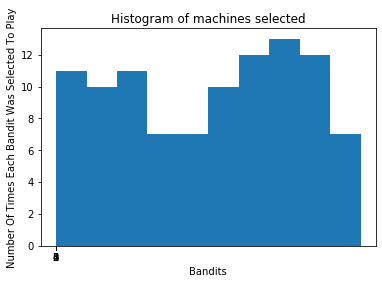

In [200]:
from collections import Counter
print("\n\nNumber Of Times Each Machine Was Selected By the Thompson Sampling Algorithm : \n",dict(Counter(sample_selected)))
plt.hist(sample_selected)
plt.title('Histogram of machines selected')
plt.xlabel('Bandits')
plt.xticks(range(0,6))
plt.ylabel('Number Of Times Each Bandit Was Selected To Play')
plt.show